In [2]:
import cv2,os

data_path='/home/shashank/Face-Mask-Detector/data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [5]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


In [7]:
np.save('data1',data)
np.save('target',target)

# Now we will train the CNN model

In [8]:
import numpy as np

data=np.load('data1.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv2D(filters=96,kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(100, 100, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=156, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: &quot;sequential_5&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 98, 98, 96)        960       
_________________________________________________________________
batch_normalization_8 (Batch (None, 98, 98, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 128)       110720    
_________________________________________________________________
batch_normalization_9 (Batch (None, 23, 23, 128)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 15

In [10]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [11]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4697WARNING:tensorflow:From /home/shashank/.local/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
31/31 [==============================] - 42s 1s/step - loss: 0.6938 - accuracy: 0.4697 - val_loss: 0.6932 - val_accuracy: 0.4798
Epoch 2/20
31/31 [==============================] - 39s 1s/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.4798
Epoch 3/20
31/31 [==============================] - 38s 1s/step - loss: 0.6932 - accuracy: 0.5040

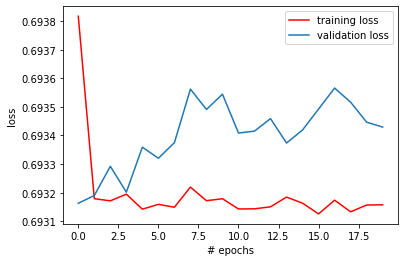

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

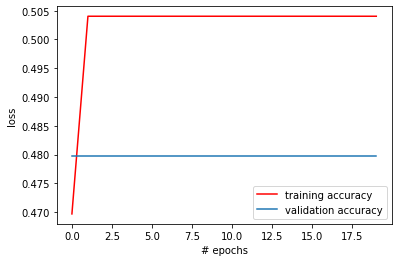

In [13]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 1s 233ms/step - loss: 0.6933 - accuracy: 0.4928
[0.6932619214057922, 0.49275362491607666]


In [15]:
from keras.models import load_model
import cv2
import numpy as np

In [21]:
model = load_model('model-001.model')
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
source=cv2.VideoCapture(0)

labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()